<a href="https://colab.research.google.com/github/Arya-Hari/ai-based-active-suspension-system/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio

^C


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from config import *
from road_generator import *
from model import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

"""
    ODE (Ordinary Differential Equation) of Quarter Car model
    :t  - timesteps
    :y0 - initial state [xb, xw, d/dt(xb), d/dt(xw)]
    :m  - tuple containing (m_body, m_wheel)
    :cs - constant related to ...
    :ks - spring stiffness
    :kw - tire stiffness

    :return [d/dt(xb), d/dt(xw), d2/dt(xb), d2/dt(xw)]
"""
def odefun(t, y0, m, cs, kw, ks):
    m1 = m[0]  # Body mass in kg
    m2 = m[1]  # Wheel mass in kg

    """ Road condition at time step t """
    t_idx = min(int(round(t/dt)), len(TIME)-1)  # Ensure t_idx is an integer
    xr = road_profile[t_idx]

    """ 1. Displacement & Velocity of body & wheel """
    xb = y0[0]                # x_body        (x1)
    xw = y0[1]                # x_wheel       (x2)
    dxb = y0[2]               # d(x_body)/dt  (dx1/dt)
    dxw = y0[3]               # d(x_wheel)/dt (dx2/dt)

    """ 2. Acceleration of body & wheel """
    d2xb = - ks/m1*(xb-xw) - cs/m1*(dxb-dxw)
    d2xw = ks/m2*(xb-xw) + cs/m2*(dxb-dxw) + kw/m2*(xr-xw)

    return [dxb, dxw, d2xb, d2xw]

def pick_sample(s, ou_action_noise):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        # action = np.clip(action, -1.0, 1.0)
        # return float(action.item())
        return action.astype(float)[0]

In [ ]:
def get_cs(a):
    ca = 600*a
    return cb + ca

def get_ks(a):
    # positive and negative stiffness has different range
    ka = 5000*a if a > 0 else 2500*a
    return kb + ka

In [ ]:
Q_origin = torch.load('./checkpoints/Q_origin_dxb_prev.pt', map_location=torch.device('cpu'))
mu_origin = torch.load('./checkpoints/mu_origin_dxb_prev.pt', map_location=torch.device('cpu'))

Q_origin.eval()
mu_origin.eval()
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(output_dim), sigma=np.ones(output_dim) * 0.)

xb_time, rl_xb_time = [], []
dxb_time, rl_dxb_time = [], []
xw_time, rl_xw_time = [], []
dxw_time, rl_dxw_time = [], []
d2xb_time, rl_d2xb_time = [], []
rl_cs = []
rl_ks = []


# Specify 'humps' or 'A' to 'F'
road_type = 'E'
if road_type == 'humps':
    road_profile = generate_road(TIME, MAX_BUMP)
else:
    road_profile = list(RoadProfile().get_profile_by_class(road_type, t_stop, dt)[1][:])

"""************************************
    1. PASSIVE SYSTEM
************************************"""
"""
    Initialize the first state of the quarter car model & RL model
     * state_ODE e R4: [x_body, x_wheel, d/dt(x_body), d/dt(x_wheel)]
"""
# [xb, xw, dxb, dxw] e R4 -> state representation of the quarter car model
s_ode = [road_profile[0], road_profile[0], 0, 0]
s_ode_prev = s_ode
print(s_ode)

for t_idx, t in enumerate(TIME):

    xb, xw, dxb, dxw = np.array(s_ode)[0:4]
    d2xb = (-cb * (dxb-dxw) - kb * (xb-xw)) / m1

    """ 1.2. Record curves"""
    xb_time.append(xb)
    dxb_time.append(dxb)
    xw_time.append(xw)
    dxw_time.append(dxw)
    d2xb_time.append(d2xb)


    yout = solve_ivp(odefun, [t, t+dt], s_ode, args=(m, cb, kw, kb ), dense_output=True)
    xb = yout.y[0,-1]    #yout.y is the solution of the ODE -> s{t+1}
    xw = yout.y[1,-1]
    dxb = yout.y[2,-1]
    dxw = yout.y[3,-1]

    s_ode_next = [xb, xw, dxb, dxw]
    s_ode = s_ode_next

"""************************************
    2. RL-BASED CONTROL
************************************"""
# [xb, xw, dxb, dxw] e R4 -> state representation of the quarter car model
s_ode = [road_profile[0], road_profile[0], 0, 0]
print(s_ode)
total_reward = 0

for t_idx, t in enumerate(TIME):

    xb, xw, dxb, dxw = np.array(s_ode)[0:4]
    dxr = (road_profile[t_idx] - road_profile[max(t_idx-1, 0)]) / dt
    xb_prev, xw_prev, dxb_prev, dxw_prev = np.array(s_ode_prev)[0:4]
    dxr_prev = (road_profile[max(t_idx-1, 0)] - road_profile[max(t_idx-2, 0)]) / dt
    # s_rl = [xb, xw, dxb, dxw, dxr] # rescale
    # s_rl = [dxb, dxw, dxr] # rescale
    s_rl = [dxb, dxw, dxr, dxb_prev, dxw_prev, dxr_prev] # rescale
    """ 1.2. Take action a{t} from RL's s{t}"""
    a = pick_sample(s_rl, ou_action_noise)
    a_cs, a_ks  = a
    """ 1.3. Compute d2/dt (x_body)"""
    d2xb = (-get_cs(a_cs) * (dxb-dxw) - get_ks(a_ks) * (xb-xw)) / m1

    """ 1.4. Record curves"""
    rl_xb_time.append(xb)
    rl_dxb_time.append(dxb)
    rl_xw_time.append(xw)
    rl_dxw_time.append(dxw)
    rl_d2xb_time.append(d2xb)
    rl_cs.append(get_cs(a_cs))
    rl_ks.append(get_ks(a_ks))

    # del xb, xw, dxb, dxw # delete these variables for debugging purpose
    """ 2a. Solve ODE for s{t+1} """
    yout = solve_ivp(odefun, [t, t+dt], s_ode, args=(m, get_cs(a_cs), kw, get_ks(a_ks) ), dense_output=True)
    # yout.y is the solution of the ODE -> s{t+1}
    xb_next, xw_next, dxb_next, dxw_next = yout.y[:,-1]
    if t_idx < len(TIME)-1:
        dxr_next = (road_profile[t_idx+1] - road_profile[t_idx]) / dt
    """ 2.2. Record next states"""
    s_ode_next = [xb_next, xw_next, dxb_next, dxw_next]
    # s_rl_next = [xb, xw, dxb, dxw, dxr]
    # s_rl_next = [dxb_next, dxw_next, dxr_next]
    s_rl_next = [dxb_next, dxw_next, dxr_next, dxb, dxw, dxr]
    """ 2.3. Check final state"""
    done = False if (t_idx < len(TIME)-1) else True

    # """ compute C_skyhook """
    # if abs(dxb) > 0.01:
    #     c_sky = cs * (dxb-dxw) / dxb
    # else:
    #     c_sky = cs
    # """ derive d2/dt(x_body) """
    # d2xb = (-ks*(xb-xw) - c_sky*dxb) / m1

    # r = 0.9*(-1000*(abs(xb)**3)) + 0.1*(-0.01*(abs(d2xb)**2))
    # r = -0.9*abs(xb) - 0.1*abs(dxb)
    r = -0.1*abs(dxb_next)
    total_reward += r

    s_ode_prev = s_ode
    s_ode = s_ode_next

print(f'Total Reward = {total_reward}')
print("\nDone")

<ipython-input-31-de266f78d3b7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Q_origin = torch.load('./checkpoints/Q_origin_dxb_prev.pt', map_location=torch.device('cpu')

[0.22528416151161926, 0.22528416151161926, 0, 0]
[0.22528416151161926, 0.22528416151161926, 0, 0]
Total Reward = -5.37331710986182

Done


## Quantiative Performance vs Passive System

In [ ]:
# xb_time, rl_xb_time = [], []
# dxb_time, rl_dxb_time = [], []
# xw_time, rl_xw_time = [], []
# dxw_time, rl_dxw_time = [], []
# d2xb_time, rl_d2xb_time = [], []

""" Body Velocity by Systems"""
q3_dxb_passive = np.quantile(np.abs(dxb_time), 0.75).mean()
q3_dxb_rl = np.quantile(np.abs(rl_dxb_time), 0.75).mean()
mean_dxb_passive = np.abs(dxb_time).mean()
mean_dxb_rl = np.abs(rl_dxb_time).mean()

q3_d2xb_passive = np.quantile(np.abs(d2xb_time), 0.75).mean()
q3_d2xb_rl = np.quantile(np.abs(rl_d2xb_time), 0.75).mean()
mean_d2xb_passive = np.abs(d2xb_time).mean()
mean_d2xb_rl = np.abs(rl_d2xb_time).mean()

pct_q3_dxb_change = round((q3_dxb_rl - q3_dxb_passive)/q3_dxb_passive, 4) * 100
pct_mean_dxb_change = round((mean_dxb_rl - mean_dxb_passive)/mean_dxb_passive, 4) * 100
pct_q3_d2xb_change = round((q3_d2xb_rl - q3_d2xb_passive)/q3_d2xb_passive, 4) * 100
pct_mean_d2xb_change = round((mean_d2xb_rl - mean_d2xb_passive)/mean_d2xb_passive, 4) * 100

print(f'Road Type = {road_type}:')
print('\tPercent change of Q3 Body Velocity:', round(pct_q3_dxb_change, 2), '%')
print('\tPercent change of Average Body Velocity:', round(pct_mean_dxb_change, 2), '%')
print('\tPercent change of Q3 Body Acceleration:', round(pct_q3_d2xb_change, 2), '%')
print('\tPercent change of Average Body Acceleration:', round(pct_mean_d2xb_change, 2), '%')

# print(np.abs(dxb_time).max(), np.abs(rl_dxb_time).max())
# print(np.abs(dxb_time).mean(), np.abs(rl_dxb_time).mean())
# print(np.abs(d2xb_time).max(), np.abs(rl_d2xb_time).max())
# print(np.abs(d2xb_time).mean(), np.abs(rl_d2xb_time).mean())

Road Type = E:
	Percent change of Q3 Body Velocity: -35.73 %
	Percent change of Average Body Velocity: -38.61 %
	Percent change of Q3 Body Acceleration: -12.62 %
	Percent change of Average Body Acceleration: -10.85 %


## Visualization

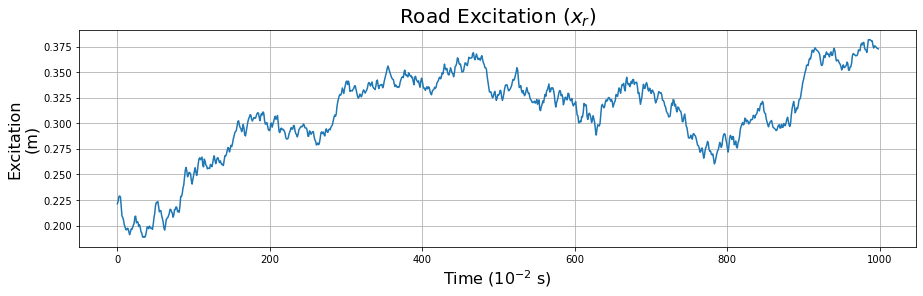

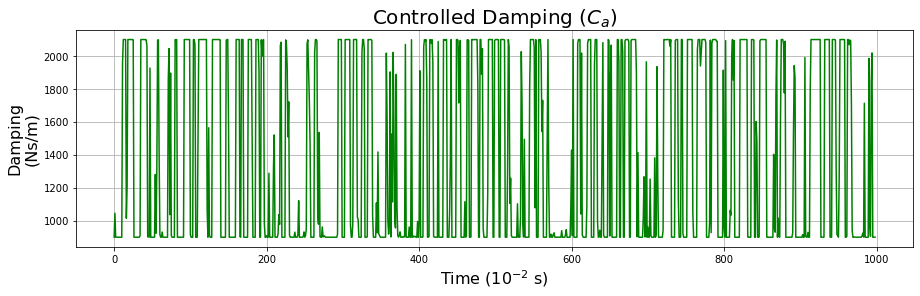

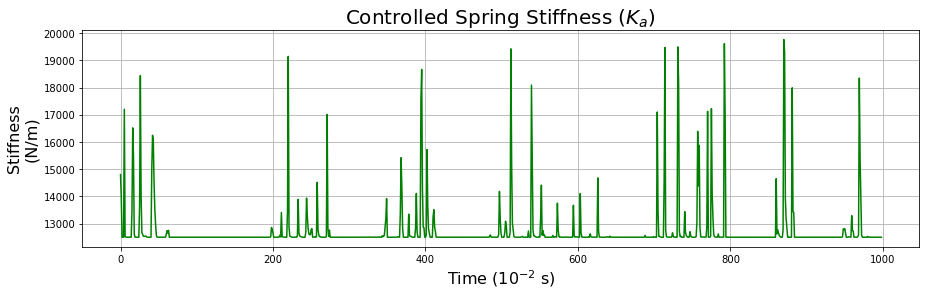

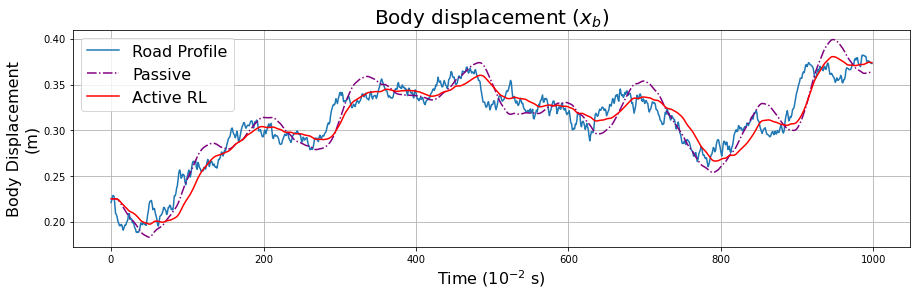

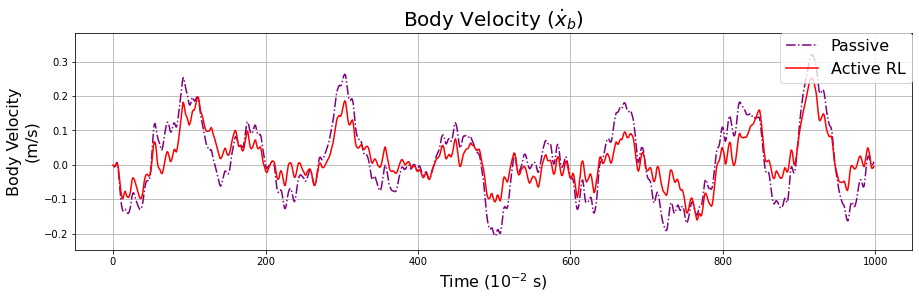

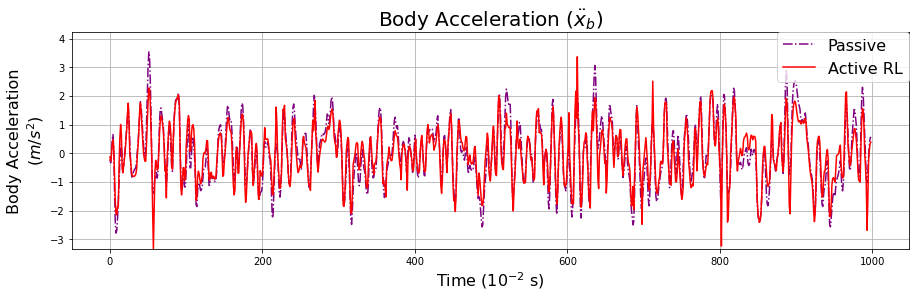

In [ ]:
""" Visualization"""
# fig, ax = plt.subplots(ncols=3, figsize=(60,5))
plt.figure(figsize=(15,4))
plt.title(f'Road Excitation ($x_r$)', fontsize=20)
plt.plot(road_profile[1:len(xb_time)])
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Excitation\n(m)', fontsize=16)
# plt.ylim([-0.1, 0.2])
plt.grid()

plt.figure(figsize=(15,4))
plt.title(f'Controlled Damping ($C_a$)', fontsize=20)
# plt.plot(cs, '--', color='darkblue')
plt.plot(rl_cs[1:], color='green')
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Damping\n(Ns/m)', fontsize=16)
# plt.ylim([min(rl_cs[1:])*0.9, max(rl_cs[1:])*1.1])
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')

plt.figure(figsize=(15,4))
plt.title(f'Controlled Spring Stiffness ($K_a$)', fontsize=20)
# plt.plot(cs, '--', color='darkblue')
plt.plot(rl_ks[1:], color='green')
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Stiffness\n(N/m)', fontsize=16)
# plt.ylim([min(rl_ks[1:])*0.99, max(rl_ks[1:])*1.01])
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')

plt.figure(figsize=(15,4))
plt.title('Body displacement ($x_b$)', fontsize=20)
plt.plot(road_profile[1:len(xb_time)], label='Road Profile')
plt.plot(xb_time[1:], '-.', color='purple', label='Passive')
plt.plot(rl_xb_time[1:], color='red', label='Active RL')
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Body Displacement\n(m)', fontsize=16)
# plt.ylim([-2*MAX_BUMP, 2*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)
plt.savefig('Sample.png')
# plt.legend(fontsize=16, bbox_to_anchor=(1, 0.35), loc=1, borderaxespad=0)

plt.figure(figsize=(15,4))
plt.title('Body Velocity ($\dot{x}_b$)', fontsize=20)
plt.plot(dxb_time[1:], '-.', color='purple', label='Passive')
plt.plot(rl_dxb_time[1:], color='red', label='Active RL')
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Body Velocity\n(m/s)', fontsize=16)
plt.ylim([min(dxb_time[1:])*1.2, max(dxb_time[1:])*1.2])
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16, bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)

plt.figure(figsize=(15,4))
plt.title('Body Acceleration ($\ddot{x}_b$)', fontsize=20)
plt.plot(d2xb_time[1:], '-.', color='purple', label='Passive')
plt.plot(rl_d2xb_time[1:], color='red', label='Active RL')
plt.xlabel('Time ($10^{-2}$ s)', fontsize=16)
plt.ylabel('Body Acceleration\n($m/s^2$)', fontsize=16)
plt.ylim([min(d2xb_time[1:])*1.2, max(d2xb_time[1:])*1.2])
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16, bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)

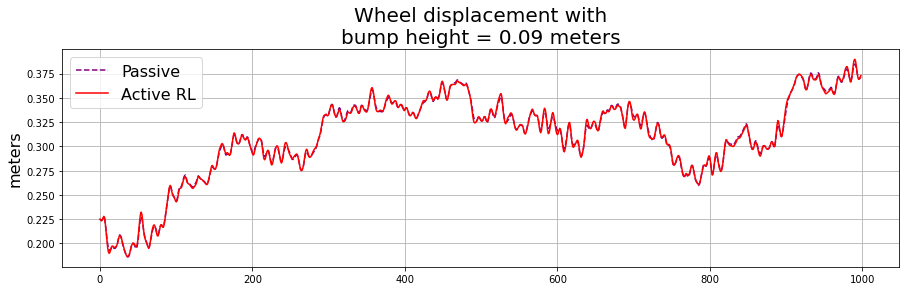

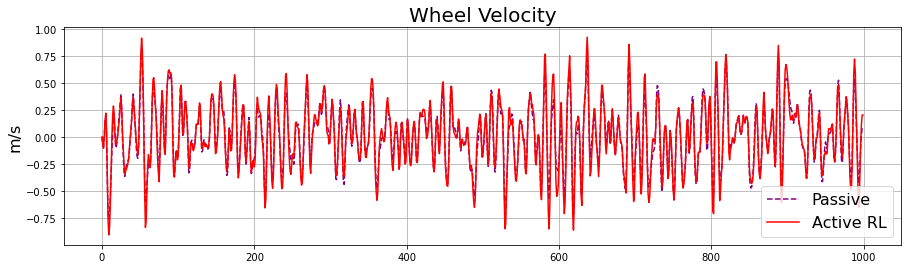

In [ ]:

plt.figure(figsize=(15,4))
plt.title(f'Wheel displacement with\nbump height = {MAX_BUMP} meters', fontsize=20)
# plt.plot(road_profile[1:(len(xb_time))], label='Road Profile')
plt.plot(xw_time[1:], '--', color='purple', label='Passive')
plt.plot(rl_xw_time[1:], color='red', label='Active RL')
plt.ylabel('meters', fontsize=16)
# plt.ylim([-2*MAX_BUMP, 2*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)


plt.figure(figsize=(15,4))
plt.title(f'Wheel Velocity', fontsize=20)
plt.plot(dxw_time[:1000], '--', color='purple', label='Passive')
plt.plot(rl_dxw_time[:1000], color='red', label='Active RL')
plt.ylabel('m/s', fontsize=16)
# ax[2].set_ylim([-1*MAX_BUMP, 1.5*MAX_BUMP])
plt.grid('--')
plt.legend(fontsize=16)